In [1]:
pip install xarray netCDF4 cartopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Try opening with explicit engine
ds_instant = xr.open_dataset('ERA5_2021_06/data_stream-oper_stepType-instant.nc', engine='netcdf4')

In [3]:
# Let's first examine the dataset structure
print("Dataset info:")
print(ds_instant)

# List all variables
print("\nAvailable variables:")
print(list(ds_instant.variables))

Dataset info:
<xarray.Dataset>
Dimensions:     (valid_time: 24, latitude: 49, longitude: 105)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2021-06-25 ... 2021-06-30T18:00:00
  * latitude    (latitude) float64 60.0 59.75 59.5 59.25 ... 48.5 48.25 48.0
  * longitude   (longitude) float64 -139.0 -138.8 -138.5 ... -113.2 -113.0
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-26T16:10 GRIB to CDM+CF via cfgrib-0.9.1...

Available variables:
['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


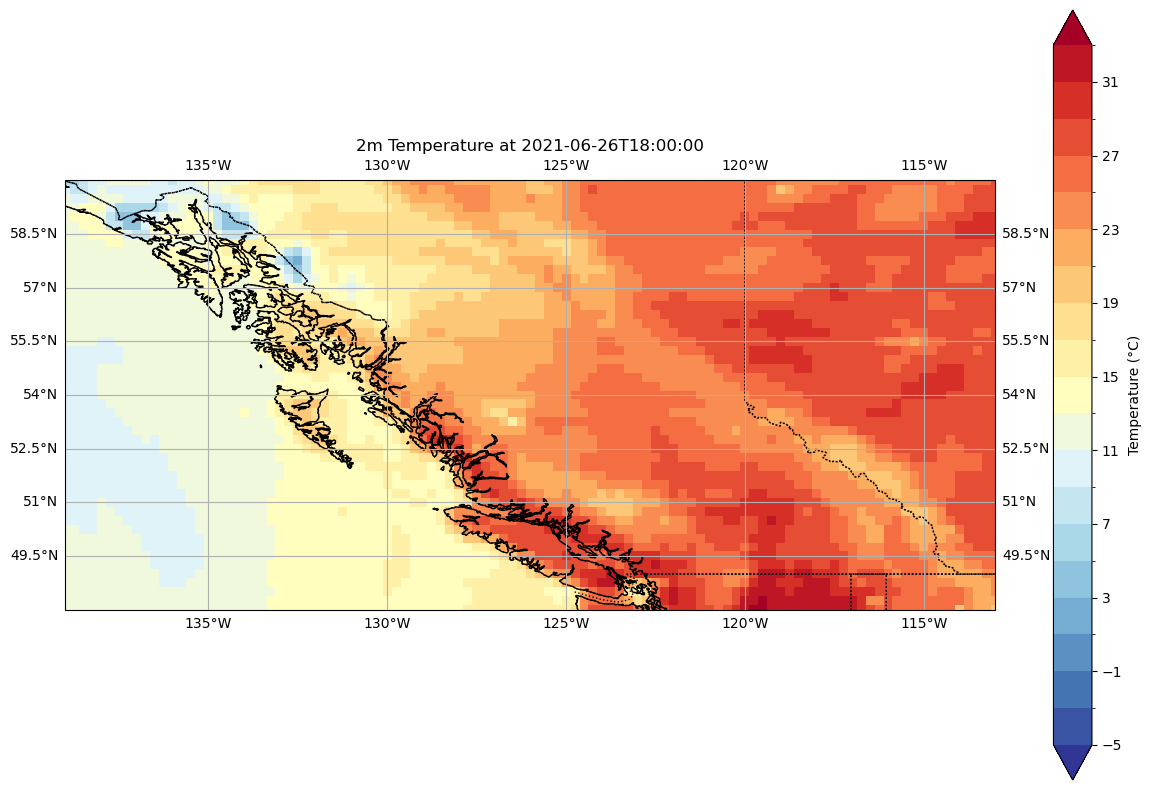

Min temperature: 1.5°C
Max temperature: 33.5°C


In [4]:
# Select 2m temperature at 6 AM on June 1st
time_slice = '2021-06-26T18:00:00'
t2m = ds_instant['t2m'].sel(valid_time=time_slice, method='nearest')

# Convert from Kelvin to Celsius
t2m = t2m - 273.15

# Create figure with map projection
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Create the contour plot
contour = t2m.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',  # Red-Yellow-Blue colormap, reversed
    levels=np.arange(-5, 35, 2),  # Temperature range from -5 to 35°C
    extend='both',
    cbar_kwargs={'label': 'Temperature (°C)'}
)

# Set title
plt.title(f'2m Temperature at {time_slice}')

# Set map extent to match your data area
ax.set_extent([-139, -113, 48, 60], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

plt.show()

# Optional: If you want to see the temperature range to adjust the plot levels
print(f"Min temperature: {float(t2m.min()):.1f}°C")
print(f"Max temperature: {float(t2m.max()):.1f}°C")

# Close the dataset when done
ds_instant.close()

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely import wkt

# ------------------------------------------------------------------
# 1. Load CSV and create GeoDataFrame
# ------------------------------------------------------------------

wn_csv = r'G:/My Drive/heatwaves/data/Vancouver_all_vars_20210625-20210630_14days/bq-results-20250312-071412-1741763682396.csv'
df_wn = pd.read_csv(wn_csv)

# Convert forecast_time to datetime
df_wn['forecast_time'] = pd.to_datetime(df_wn['forecast_time'], errors='coerce')

# Convert WKT strings to geometry
df_wn['geometry'] = df_wn['geography_polygon_text'].apply(wkt.loads)
gdf_wn = gpd.GeoDataFrame(df_wn, geometry='geometry', crs='EPSG:4326')


In [6]:
# ------------------------------------------------------------------
# Preview dataset to inspect structure
# ------------------------------------------------------------------

# Show available forecast times (unique + sorted)
print("\n✅ Available forecast times:")
print(gdf_wn['forecast_time'].dropna().sort_values().unique()[:10])  # show first 10 times

# Show column names
print("\n📋 Column names:")
print(gdf_wn.columns.tolist())

# Show a few sample rows
print("\n🧾 Sample rows:")
print(gdf_wn[['forecast_time', 'ensemble_member', '2m_temperature', 'geometry']].head())



✅ Available forecast times:
<DatetimeArray>
['2021-06-25 00:00:00+00:00', '2021-06-25 06:00:00+00:00',
 '2021-06-25 12:00:00+00:00', '2021-06-25 18:00:00+00:00',
 '2021-06-26 00:00:00+00:00', '2021-06-26 06:00:00+00:00',
 '2021-06-26 12:00:00+00:00', '2021-06-26 18:00:00+00:00',
 '2021-06-27 00:00:00+00:00', '2021-06-27 06:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]

📋 Column names:
['init_time', 'forecast_time', 'ensemble_member', 'geography_polygon_text', 'geography_text', 'total_precipitation_12hr', '100m_u_component_of_wind', '100m_v_component_of_wind', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'mean_sea_level_pressure', 'sea_surface_temperature', 'geometry']

🧾 Sample rows:
              forecast_time  ensemble_member  2m_temperature  \
0 2021-06-30 18:00:00+00:00                0      282.027740   
1 2021-06-30 18:00:00+00:00                0      286.233307   
2 2021-06-30 18:00:00+00:00                0      283.709473   
3 2021-06-30 18:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------
# EVALUATION: WeatherNext vs. ERA5 in °C
# ---------------------------------------------------------

# 1) Pick a time slice & filter WeatherNext
time_slice = '2021-06-26T18:00:00'
gdf_eval = gdf_wn[gdf_wn['forecast_time'] == pd.to_datetime(time_slice, utc=True)].copy()
print(f"Number of WeatherNext records for {time_slice}: {len(gdf_eval)}")

if gdf_eval.empty:
    raise ValueError(f"No WeatherNext data found for {time_slice}")

# 2) Compute centroids (project to UTM for accuracy, then back to lat/lon)
gdf_eval_utm = gdf_eval.to_crs(epsg=32610)
gdf_eval_utm['centroid'] = gdf_eval_utm.geometry.centroid
gdf_eval['centroid'] = gdf_eval_utm['centroid'].to_crs(epsg=4326)

# 3) Sample ERA5 at each centroid
era5_vals = []
for idx, row in gdf_eval.iterrows():
    lat = row['centroid'].y
    lon = row['centroid'].x
    try:
        # 't2m' is already a single-time DataArray in °C
        val = t2m.sel(latitude=lat, longitude=lon, method='nearest').values.item()
    except Exception as e:
        print(f"ERA5 sampling error at index {idx}: {e}")
        val = np.nan
    era5_vals.append(val)

gdf_eval['era5_temp_c'] = era5_vals  # Store ERA5 values in new column


Number of WeatherNext records for 2021-06-26T18:00:00: 50750


In [32]:
# After:
# gdf_eval = gdf_wn[gdf_wn['forecast_time'] == pd.to_datetime(time_slice, utc=True)].copy()

unique_ems = sorted(gdf_eval['ensemble_member'].unique())
print(f"Unique ensemble_member values: {unique_ems}")
print(f"Count of unique ensemble members: {len(unique_ems)}")


Unique ensemble_member values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Count of unique ensemble members: 50


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import geopandas as gpd

# ---------------------------------------------------------
# 1) Filter WeatherNext to a Single Forecast Time
# ---------------------------------------------------------
time_slice = '2021-06-26T18:00:00'
gdf_slice = gdf_wn[gdf_wn['forecast_time'] == pd.to_datetime(time_slice, utc=True)].copy()
print(f"Number of WeatherNext records for {time_slice}: {len(gdf_slice)}")

if gdf_slice.empty:
    raise ValueError(f"No WeatherNext data found for {time_slice}")

Number of WeatherNext records for 2021-06-26T18:00:00: 50750


In [38]:
gdf_slice

,init_time,forecast_time,ensemble_member,geography_polygon_text,geography_text,total_precipitation_12hr,100m_u_component_of_wind,100m_v_component_of_wind,10m_u_component_of_wind,10m_v_component_of_wind,2m_temperature,mean_sea_level_pressure,sea_surface_temperature,geometry
812000,2021-06-12 06:00:00 UTC,2021-06-26 18:00:00+00:00,0,"POLYGON((-122.875 48.875, -122.875 49.125, -12...",POINT(-123 49),4.869536e-06,2.814872,-3.844645,2.699520,-1.972151,295.414093,101761.078125,NaN,"POLYGON ((-122.875 48.875, -122.875 49.125, -1..."
812001,2021-06-12 06:00:00 UTC,2021-06-26 18:00:00+00:00,0,"POLYGON((-123.625 48.625, -123.625 48.875, -12...",POINT(-123.75 48.75),1.604471e-05,-0.789102,-4.146704,-0.095456,-3.148166,302.485229,101760.304688,NaN,"POLYGON ((-123.625 48.625, -123.625 48.875, -1..."
812002,2021-06-12 06:00:00 UTC,2021-06-26 18:00:00+00:00,0,"POLYGON((-123.125 48.875, -123.125 49.125, -12...",POINT(-123.25 49),-7.339055e-06,1.858833,-4.871130,2.305873,-3.020653,291.162537,101758.476562,288.513428,"POLYGON ((-123.125 48.875, -123.125 49.125, -1..."
812003,2021-06-12 06:00:00 UTC,2021-06-26 18:00:00+00:00,0,"POLYGON((-122.625 49.125, -122.625 49.375, -12...",POINT(-122.75 49.25),-4.642294e-06,-0.094971,0.001282,0.031044,0.050415,305.477539,101756.117188,NaN,"POLYGON ((-122.625 49.125, -122.625 49.375, -1..."
812004,2021-06-12 06:00:00 UTC,2021-06-26 18:00:00+00:00,0,"POLYGON((-122.875 49.125, -122.875 49.375, -12...",POINT(-123 49.25),2.043706e-05,0.027362,1.875649,0.207224,1.486964,302.486511,101762.890625,NaN,"POLYGON ((-122.875 49.125, -122.875 49.375, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862745,2021-06-26 06:00:00 UTC,2021-06-26 18:00:00+00:00,9,"POLYGON((-123.125 48.625, -123.125 48.875, -12...",POINT(-123.25 48.75),4.004920e-06,0.747786,-6.285000,0.805584,-5.485799,290.783905,101698.695312,288.761536,"POLYGON ((-123.125 48.625, -123.125 48.875, -1..."
862746,2021-06-26 06:00:00 UTC,2021-06-26 18:00:00+00:00,9,"POLYGON((-122.625 49.625, -122.625 49.875, -12...",POINT(-122.75 49.75),4.681060e-07,-0.536836,-0.311973,-0.331230,-0.139307,301.205261,101916.976562,NaN,"POLYGON ((-122.625 49.625, -122.625 49.875, -1..."
862747,2021-06-26 06:00:00 UTC,2021-06-26 18:00:00+00:00,9,"POLYGON((-122.375 49.625, -122.375 49.875, -12...",POINT(-122.5 49.75),5.095731e-06,-1.687294,-0.673189,-1.296986,-0.476081,301.008972,101933.304688,NaN,"POLYGON ((-122.375 49.625, -122.375 49.875, -1..."
862748,2021-06-26 06:00:00 UTC,2021-06-26 18:00:00+00:00,9,"POLYGON((-123.625 48.625, -123.625 48.875, -12...",POINT(-123.75 48.75),-1.688849e-05,-2.335165,-1.042744,-1.799720,-0.737897,301.575928,101670.445312,NaN,"POLYGON ((-123.625 48.625, -123.625 48.875, -1..."


In [40]:

# ---------------------------------------------------------
# 2) Average Over Ensemble Members
#    One row per geometry (polygon) with mean temperature
# ---------------------------------------------------------
# Group by geometry to collapse all ensemble members into one mean
df_mean = gdf_slice.groupby('geometry', as_index=False)['2m_temperature'].mean()
# Convert Kelvin -> Celsius
df_mean['wn_temp_c'] = df_mean['2m_temperature'] - 273.15

# Convert to a GeoDataFrame
gdf_mean = gpd.GeoDataFrame(df_mean, geometry='geometry', crs='EPSG:4326')


In [42]:
gdf_mean

,geometry,2m_temperature,wn_temp_c
0,"POLYGON ((-123.875 48.625, -123.875 48.875, -1...",300.165609,27.015609
1,"POLYGON ((-123.875 48.875, -123.875 49.125, -1...",299.918266,26.768266
2,"POLYGON ((-123.625 48.875, -123.625 49.125, -1...",297.205751,24.055751
3,"POLYGON ((-123.625 48.625, -123.625 48.875, -1...",300.383805,27.233805
4,"POLYGON ((-123.375 48.625, -123.375 48.875, -1...",298.228665,25.078665
5,"POLYGON ((-123.125 48.625, -123.125 48.875, -1...",289.995637,16.845637
6,"POLYGON ((-123.125 48.875, -123.125 49.125, -1...",290.242719,17.092719
7,"POLYGON ((-123.375 48.875, -123.375 49.125, -1...",290.773342,17.623342
8,"POLYGON ((-123.125 49.125, -123.125 49.375, -1...",291.131849,17.981849
9,"POLYGON ((-123.375 49.125, -123.375 49.375, -1...",291.184602,18.034602


In [44]:
# ---------------------------------------------------------
# 3) Compute Centroids & Sample ERA5
# ---------------------------------------------------------
# Project to UTM for accurate centroids
gdf_mean_utm = gdf_mean.to_crs(epsg=32610)
gdf_mean_utm['centroid'] = gdf_mean_utm.geometry.centroid
# Convert centroids back to EPSG:4326
gdf_mean['centroid'] = gdf_mean_utm['centroid'].to_crs(epsg=4326)

# Now sample ERA5 at each centroid
era5_vals = []
for idx, row in gdf_mean.iterrows():
    lat = row['centroid'].y
    lon = row['centroid'].x
    try:
        # 't2m' is your ERA5 single-time DataArray already in °C
        val = t2m.sel(latitude=lat, longitude=lon, method='nearest').values.item()
    except Exception as e:
        print(f"ERA5 sampling error at index {idx}: {e}")
        val = np.nan
    era5_vals.append(val)

gdf_mean['era5_temp_c'] = era5_vals

In [46]:
gdf_mean

,geometry,2m_temperature,wn_temp_c,centroid,era5_temp_c
0,"POLYGON ((-123.875 48.625, -123.875 48.875, -1...",300.165609,27.015609,POINT (-124 48.74997),31.379303
1,"POLYGON ((-123.875 48.875, -123.875 49.125, -1...",299.918266,26.768266,POINT (-124 48.99996),30.861725
2,"POLYGON ((-123.625 48.875, -123.625 49.125, -1...",297.205751,24.055751,POINT (-123.75 48.99996),31.264069
3,"POLYGON ((-123.625 48.625, -123.625 48.875, -1...",300.383805,27.233805,POINT (-123.75 48.74997),31.510162
4,"POLYGON ((-123.375 48.625, -123.375 48.875, -1...",298.228665,25.078665,POINT (-123.5 48.74997),28.873444
5,"POLYGON ((-123.125 48.625, -123.125 48.875, -1...",289.995637,16.845637,POINT (-123.25 48.74997),22.217194
6,"POLYGON ((-123.125 48.875, -123.125 49.125, -1...",290.242719,17.092719,POINT (-123.25 48.99996),27.012115
7,"POLYGON ((-123.375 48.875, -123.375 49.125, -1...",290.773342,17.623342,POINT (-123.5 48.99996),29.168365
8,"POLYGON ((-123.125 49.125, -123.125 49.375, -1...",291.131849,17.981849,POINT (-123.25 49.24996),27.447662
9,"POLYGON ((-123.375 49.125, -123.375 49.375, -1...",291.184602,18.034602,POINT (-123.5 49.24996),26.947662


Number of WeatherNext records for 2021-06-26T18:00:00: 50750


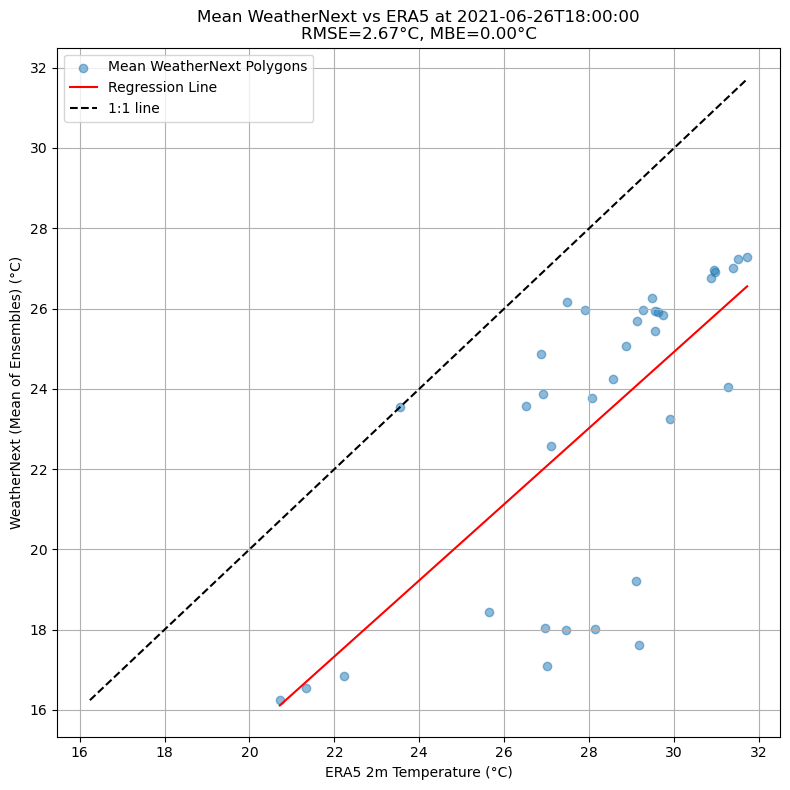


Evaluation metrics at 2021-06-26T18:00:00:
  RMSE: 2.67 °C
  MBE:  0.00 °C


In [34]:
# ---------------------------------------------------------
# 4) Plot Scatter & Regression of Mean WeatherNext vs ERA5
# ---------------------------------------------------------
wn_clean = gdf_mean['wn_temp_c']
era5_clean = gdf_mean['era5_temp_c']

# Remove any NaNs
mask = ~np.isnan(wn_clean) & ~np.isnan(era5_clean)
wn_clean = wn_clean[mask]
era5_clean = era5_clean[mask]

# Fit linear regression
model = LinearRegression()
X = era5_clean.values.reshape(-1, 1)
y = wn_clean.values
model.fit(X, y)
y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
mbe = np.mean(y_pred - y)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(era5_clean, wn_clean, alpha=0.5, label='Mean WeatherNext Polygons')

# Regression line
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)
ax.plot(x_line, y_line, 'r-', label='Regression Line')

# 1:1 line
min_t = min(era5_clean.min(), wn_clean.min())
max_t = max(era5_clean.max(), wn_clean.max())
ax.plot([min_t, max_t], [min_t, max_t], 'k--', label='1:1 line')

ax.set_xlabel("ERA5 2m Temperature (°C)")
ax.set_ylabel("WeatherNext (Mean of Ensembles) (°C)")
ax.set_title(f"Mean WeatherNext vs ERA5 at {time_slice}\nRMSE={rmse:.2f}°C, MBE={mbe:.2f}°C")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

print(f"\nEvaluation metrics at {time_slice}:")
print(f"  RMSE: {rmse:.2f} °C")
print(f"  MBE:  {mbe:.2f} °C")


In [50]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------
# ASSUMPTIONS:
# - gdf_wn is your WeatherNext GeoDataFrame with columns:
#      'forecast_time' (datetime),
#      '2m_temperature' (in Kelvin),
#      'geometry' (WKT converted to shapely geometries),
#      and 'ensemble_member'
# - t2m is your ERA5 single-time DataArray in °C (already converted)
# ---------------------------------------------------------

# Directory to save plots
save_dir = r"G:\My Drive\heatwaves\sub-project 3\plots"
os.makedirs(save_dir, exist_ok=True)

# 1) Identify all unique forecast times in WeatherNext
all_times = sorted(gdf_wn['forecast_time'].dropna().unique())
print(f"Found {len(all_times)} unique forecast times in WeatherNext.")

# 2) Loop over all forecast times
for i, time_slice in enumerate(all_times):
    # A) Filter WeatherNext to this time_slice
    gdf_slice = gdf_wn[gdf_wn['forecast_time'] == time_slice].copy()
    print(f"\nTime: {time_slice}, WeatherNext records: {len(gdf_slice)}")
    
    if gdf_slice.empty:
        print("No data for this time slice — skipping.")
        continue
    
    # B) Average over ensemble members: one value per polygon
    # Group by geometry (each polygon) and average the '2m_temperature'
    df_mean = gdf_slice.groupby('geometry', as_index=False)['2m_temperature'].mean()
    # Convert Kelvin to Celsius
    df_mean['wn_temp_c'] = df_mean['2m_temperature'] - 273.15
    gdf_mean = gpd.GeoDataFrame(df_mean, geometry='geometry', crs='EPSG:4326')
    
    # C) Compute centroids and sample ERA5 at each centroid
    gdf_mean_utm = gdf_mean.to_crs(epsg=32610)
    gdf_mean_utm['centroid'] = gdf_mean_utm.geometry.centroid
    gdf_mean['centroid'] = gdf_mean_utm['centroid'].to_crs(epsg=4326)
    
    era5_vals = []
    for idx, row in gdf_mean.iterrows():
        lat = row['centroid'].y
        lon = row['centroid'].x
        try:
            # t2m is your ERA5 DataArray in °C
            val = t2m.sel(latitude=lat, longitude=lon, method='nearest').values.item()
        except Exception as e:
            print(f"ERA5 sampling error at index {idx}: {e}")
            val = np.nan
        era5_vals.append(val)
    gdf_mean['era5_temp_c'] = era5_vals
    
    # D) Prepare data for plotting
    wn_clean = gdf_mean['wn_temp_c']
    era5_clean = gdf_mean['era5_temp_c']
    
    # Remove any rows with NaNs
    mask = ~np.isnan(wn_clean) & ~np.isnan(era5_clean)
    wn_clean = wn_clean[mask]
    era5_clean = era5_clean[mask]
    
    if len(wn_clean) == 0:
        print("No valid data after removing NaNs. Skipping this time slice.")
        continue
    
    # E) Fit linear regression: ERA5 as predictor, WeatherNext as response
    model = LinearRegression()
    X = era5_clean.values.reshape(-1, 1)
    y = wn_clean.values
    model.fit(X, y)
    y_pred = model.predict(X)
    
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mbe = np.mean(y_pred - y)
    
    # F) Create scatter + regression plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(era5_clean, wn_clean, alpha=0.5, label='Mean WeatherNext Polygons')
    
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    ax.plot(x_line, y_line, 'r-', linewidth=2, label='Regression Line')
    
    # Plot 1:1 reference line
    min_t = min(era5_clean.min(), wn_clean.min())
    max_t = max(era5_clean.max(), wn_clean.max())
    ax.plot([min_t, max_t], [min_t, max_t], 'k--', label='1:1 line')
    
    ax.set_xlabel("ERA5 2m Temperature (°C)")
    ax.set_ylabel("Mean WeatherNext 2m Temperature (°C)")
    ax.set_title(
        f"Mean WeatherNext vs ERA5 at {pd.to_datetime(time_slice).strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"RMSE={rmse:.2f}°C, MBE={mbe:.2f}°C"
    )
    ax.legend()
    ax.grid()
    plt.tight_layout()
    
    # Save the plot
    filename = os.path.join(save_dir, f"wn_vs_era5_{i:02d}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved plot for time {time_slice} as {filename}")


Found 24 unique forecast times in WeatherNext.

Time: 2021-06-25 00:00:00+00:00, WeatherNext records: 49000
Saved plot for time 2021-06-25 00:00:00+00:00 as G:\My Drive\heatwaves\sub-project 3\plots\wn_vs_era5_00.png

Time: 2021-06-25 06:00:00+00:00, WeatherNext records: 49000
Saved plot for time 2021-06-25 06:00:00+00:00 as G:\My Drive\heatwaves\sub-project 3\plots\wn_vs_era5_01.png

Time: 2021-06-25 12:00:00+00:00, WeatherNext records: 50750
Saved plot for time 2021-06-25 12:00:00+00:00 as G:\My Drive\heatwaves\sub-project 3\plots\wn_vs_era5_02.png

Time: 2021-06-25 18:00:00+00:00, WeatherNext records: 50750
Saved plot for time 2021-06-25 18:00:00+00:00 as G:\My Drive\heatwaves\sub-project 3\plots\wn_vs_era5_03.png

Time: 2021-06-26 00:00:00+00:00, WeatherNext records: 50750
Saved plot for time 2021-06-26 00:00:00+00:00 as G:\My Drive\heatwaves\sub-project 3\plots\wn_vs_era5_04.png

Time: 2021-06-26 06:00:00+00:00, WeatherNext records: 50750
Saved plot for time 2021-06-26 06:00:00+00

In [62]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt

# -------------------------------
# PARAMETERS
# -------------------------------
extreme_threshold = 30.0  # Extreme high temperature threshold in °C

# -------------------------------
# ASSUMPTIONS:
# - gdf_wn is your WeatherNext GeoDataFrame with columns:
#      'forecast_time' (datetime),
#      '2m_temperature' (in Kelvin),
#      'geometry' (already converted from WKT),
#      and 'ensemble_member'
# - t2m is your ERA5 single-time DataArray in °C (already converted)
# -------------------------------

# Directory to save results
results_dir = r"G:\My Drive\heatwaves\sub-project 3\results"
os.makedirs(results_dir, exist_ok=True)

# Initialize an empty DataFrame to store extreme event rows across time slices
extreme_events = pd.DataFrame()

# Get all unique forecast times from WeatherNext
all_times = sorted(gdf_wn['forecast_time'].dropna().unique())
print(f"Found {len(all_times)} unique forecast times in WeatherNext.")

# Loop over each forecast time
for time_slice in all_times:
    # A) Filter WeatherNext for this time slice (ensure UTC)
    gdf_slice = gdf_wn[gdf_wn['forecast_time'] == pd.to_datetime(time_slice, utc=True)].copy()
    print(f"\nTime: {time_slice}, WeatherNext records: {len(gdf_slice)}")
    if gdf_slice.empty:
        continue

    # B) Average over ensemble members: one value per polygon
    # Group by geometry and average the '2m_temperature'
    df_mean = gdf_slice.groupby('geometry', as_index=False)['2m_temperature'].mean()
    # Convert Kelvin -> Celsius
    df_mean['wn_temp_c'] = df_mean['2m_temperature'] - 273.15
    gdf_mean = gpd.GeoDataFrame(df_mean, geometry='geometry', crs='EPSG:4326')
    
    # Add the forecast time (all rows share the same time)
    gdf_mean['forecast_time'] = pd.to_datetime(time_slice, utc=True)
    
    # C) Compute centroids and sample ERA5 at each centroid
    gdf_mean_utm = gdf_mean.to_crs(epsg=32610)
    gdf_mean_utm['centroid'] = gdf_mean_utm.geometry.centroid
    gdf_mean['centroid'] = gdf_mean_utm['centroid'].to_crs(epsg=4326)
    
    era5_vals = []
    for idx, row in gdf_mean.iterrows():
        lat = row['centroid'].y
        lon = row['centroid'].x
        try:
            # t2m is your ERA5 DataArray in °C
            val = t2m.sel(latitude=lat, longitude=lon, method='nearest').values.item()
        except Exception as e:
            print(f"ERA5 sampling error at index {idx}: {e}")
            val = np.nan
        era5_vals.append(val)
    gdf_mean['era5_temp_c'] = era5_vals
    
    # D) Flag extreme events based on ERA5 data
    gdf_mean['extreme_era5'] = gdf_mean['era5_temp_c'] > extreme_threshold
    gdf_mean['extreme_wn']   = gdf_mean['wn_temp_c']   > extreme_threshold
    
    # E) Extract centroid coordinates for clarity
    gdf_mean['Latitude']  = gdf_mean['centroid'].apply(lambda pt: pt.y)
    gdf_mean['Longitude'] = gdf_mean['centroid'].apply(lambda pt: pt.x)
    
    # F) Filter rows where ERA5 indicates an extreme event
    extreme_table = gdf_mean[gdf_mean['extreme_era5']].copy()
    
    # Include forecast_time in the columns
    cols_to_show = ['forecast_time', 'Latitude', 'Longitude', 'era5_temp_c', 'wn_temp_c', 'extreme_era5', 'extreme_wn']
    extreme_table = extreme_table[cols_to_show].sort_values(by='era5_temp_c', ascending=False)
    
    # Append results from this time slice to the overall table
    extreme_events = pd.concat([extreme_events, extreme_table], ignore_index=True)

# Save the full summary table to CSV
results_filename = os.path.join(results_dir, "extreme_events.csv")
extreme_events.to_csv(results_filename, index=False)
print(f"\nSaved extreme events table to {results_filename}")


Found 24 unique forecast times in WeatherNext.

Time: 2021-06-25 00:00:00+00:00, WeatherNext records: 49000

Time: 2021-06-25 06:00:00+00:00, WeatherNext records: 49000

Time: 2021-06-25 12:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-25 18:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-26 00:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-26 06:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-26 12:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-26 18:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-27 00:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-27 06:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-27 12:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-27 18:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-28 00:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-28 06:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-28 12:00:00+00:00, WeatherNext records: 50750

Time: 2021-06-28 18:00:00+00:00, Weat

In [54]:
import numpy as np
import pandas as pd

# -------------------------------
# PARAMETERS
# -------------------------------
extreme_threshold = 30.0  # Extreme high temperature threshold in °C

# -------------------------------
# ASSUMPTION:
# gdf_mean is a GeoDataFrame for one forecast time slice that has:
#   - 'wn_temp_c': Mean WeatherNext 2m temperature (°C)
#   - 'era5_temp_c': ERA5 2m temperature (°C)
#   - 'centroid': a shapely Point with the location of the polygon centroid
# -------------------------------

# Create binary flags for extreme events
gdf_mean['extreme_era5'] = gdf_mean['era5_temp_c'] > extreme_threshold
gdf_mean['extreme_wn']   = gdf_mean['wn_temp_c']   > extreme_threshold

# Extract centroid coordinates (latitude and longitude)
gdf_mean['Latitude']  = gdf_mean['centroid'].apply(lambda pt: pt.y)
gdf_mean['Longitude'] = gdf_mean['centroid'].apply(lambda pt: pt.x)

# Create a summary table for extreme events according to ERA5
extreme_table = gdf_mean[gdf_mean['extreme_era5']].copy()

# Select and order the columns to display
columns_to_show = ['Latitude', 'Longitude', 'era5_temp_c', 'wn_temp_c', 'extreme_era5', 'extreme_wn']
extreme_table = extreme_table[columns_to_show].sort_values(by='era5_temp_c', ascending=False)

# Print the table
print(f"Extreme High Temperature Events (ERA5 > {extreme_threshold}°C):")
print(extreme_table.to_string(index=False))

# Optionally, print summary counts:
total_extremes = len(extreme_table)
print(f"\nTotal number of extreme events (ERA5 > {extreme_threshold}°C): {total_extremes}")


Extreme High Temperature Events (ERA5 > 30.0°C):
 Latitude   Longitude  era5_temp_c  wn_temp_c  extreme_era5  extreme_wn
49.249964 -122.500000    31.717194  22.157889          True       False
48.749966 -123.750000    31.510162  23.313737          True       False
48.749966 -123.999999    31.379303  22.416924          True       False
48.999965 -123.750000    31.264069  21.312411          True       False
49.249964 -122.750000    30.951569  21.779480          True       False
48.999965 -122.500000    30.943756  22.673918          True       False
48.999965 -123.999999    30.861725  23.257724          True       False

Total number of extreme events (ERA5 > 30.0°C): 7


Number of extreme events (ERA5 > 30.0°C): 7


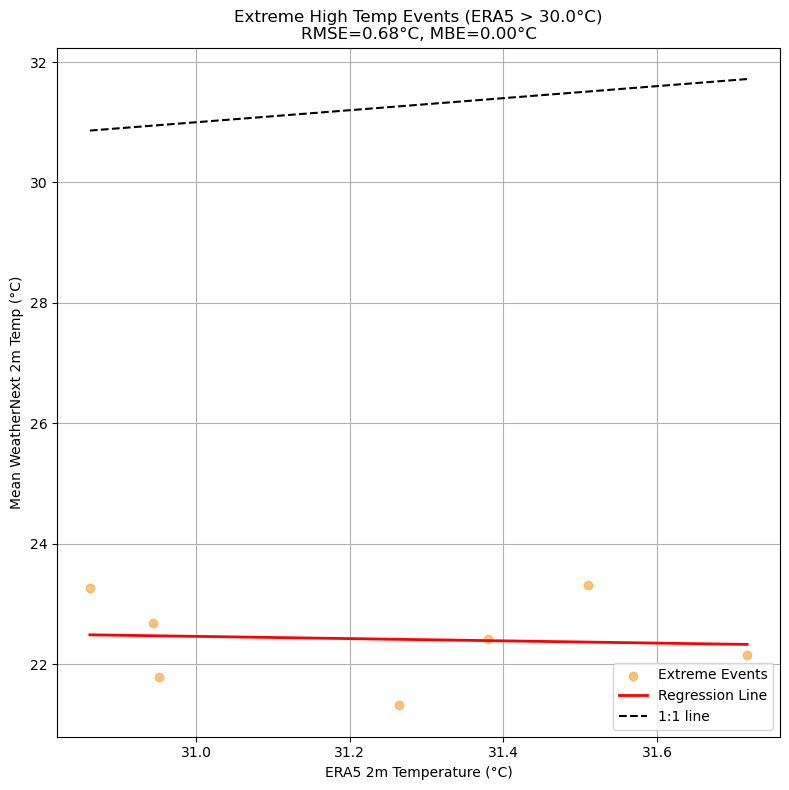


Binary Extreme Event Evaluation:
Hit: 0
False Alarm: 0
Miss: 7
Correct Rejection: 28
Probability of Detection (POD): 0.00
False Alarm Ratio (FAR): nan


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# -------------------------------
# PARAMETERS
# -------------------------------
extreme_threshold = 30.0  # Extreme high temperature threshold in °C

# -------------------------------
# ASSUMPTION:
# gdf_mean is a GeoDataFrame for one forecast time with:
#   - 'wn_temp_c': Mean WeatherNext 2m temperature (°C) (averaged over ensembles)
#   - 'era5_temp_c': ERA5 2m temperature (°C) sampled at the polygon centroid
# -------------------------------

# --- Continuous Evaluation for Extreme High Temperature Events ---
# Filter to only the polygons where ERA5 temperature is above the threshold.
gdf_extreme = gdf_mean[gdf_mean['era5_temp_c'] > extreme_threshold].copy()
print(f"Number of extreme events (ERA5 > {extreme_threshold}°C): {len(gdf_extreme)}")

if len(gdf_extreme) > 0:
    wn_extreme = gdf_extreme['wn_temp_c']
    era5_extreme = gdf_extreme['era5_temp_c']
    
    # Fit a linear regression model on the extreme subset
    model_ext = LinearRegression()
    X_ext = era5_extreme.values.reshape(-1, 1)
    y_ext = wn_extreme.values
    model_ext.fit(X_ext, y_ext)
    y_ext_pred = model_ext.predict(X_ext)
    
    rmse_ext = np.sqrt(mean_squared_error(y_ext, y_ext_pred))
    mbe_ext = np.mean(y_ext_pred - y_ext)
    
    # Plot scatter and regression line for extreme events
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(era5_extreme, wn_extreme, alpha=0.5, color='darkorange', label='Extreme Events')
    x_line_ext = np.linspace(X_ext.min(), X_ext.max(), 100).reshape(-1, 1)
    y_line_ext = model_ext.predict(x_line_ext)
    ax.plot(x_line_ext, y_line_ext, 'r-', linewidth=2, label='Regression Line')
    ax.plot([X_ext.min(), X_ext.max()], [X_ext.min(), X_ext.max()], 'k--', label='1:1 line')
    ax.set_xlabel("ERA5 2m Temperature (°C)")
    ax.set_ylabel("Mean WeatherNext 2m Temp (°C)")
    ax.set_title(f"Extreme High Temp Events (ERA5 > {extreme_threshold}°C)\nRMSE={rmse_ext:.2f}°C, MBE={mbe_ext:.2f}°C")
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()
else:
    print(f"No extreme events found with ERA5 temperature > {extreme_threshold}°C.")

# --- Binary Evaluation for Extreme High Temperature Prediction ---
# Create binary flags for extreme events for both ERA5 and WeatherNext forecasts.
gdf_mean['extreme_era5'] = gdf_mean['era5_temp_c'] > extreme_threshold
gdf_mean['extreme_wn']   = gdf_mean['wn_temp_c']   > extreme_threshold

# Calculate contingency metrics.
hit = np.sum((gdf_mean['extreme_era5'] == True) & (gdf_mean['extreme_wn'] == True))
false_alarm = np.sum((gdf_mean['extreme_era5'] == False) & (gdf_mean['extreme_wn'] == True))
miss = np.sum((gdf_mean['extreme_era5'] == True) & (gdf_mean['extreme_wn'] == False))
correct_rejection = np.sum((gdf_mean['extreme_era5'] == False) & (gdf_mean['extreme_wn'] == False))

print("\nBinary Extreme Event Evaluation:")
print(f"Hit: {hit}")
print(f"False Alarm: {false_alarm}")
print(f"Miss: {miss}")
print(f"Correct Rejection: {correct_rejection}")

# Compute binary metrics: Probability of Detection (POD) and False Alarm Ratio (FAR)
if (hit + miss) > 0:
    pod = hit / (hit + miss)
else:
    pod = np.nan
if (hit + false_alarm) > 0:
    far = false_alarm / (hit + false_alarm)
else:
    far = np.nan

print(f"Probability of Detection (POD): {pod:.2f}")
print(f"False Alarm Ratio (FAR): {far:.2f}")


Number of WeatherNext records for 2021-06-26T18:00:00: 50750


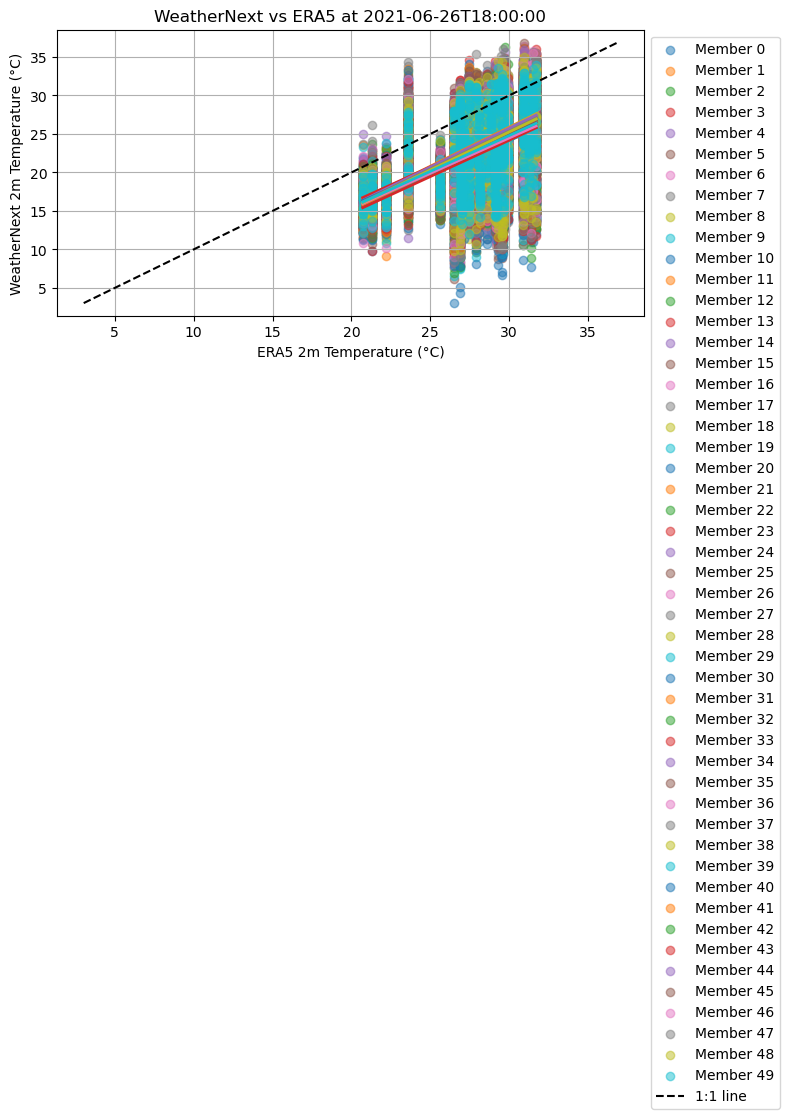


Evaluation summary:
Member 0: RMSE=4.69°C, MBE=-0.00°C
Member 1: RMSE=4.47°C, MBE=-0.00°C
Member 2: RMSE=5.52°C, MBE=-0.00°C
Member 3: RMSE=4.50°C, MBE=-0.00°C
Member 4: RMSE=4.84°C, MBE=0.00°C
Member 5: RMSE=5.14°C, MBE=-0.00°C
Member 6: RMSE=4.71°C, MBE=-0.00°C
Member 7: RMSE=5.17°C, MBE=0.00°C
Member 8: RMSE=4.69°C, MBE=-0.00°C
Member 9: RMSE=4.91°C, MBE=0.00°C
Member 10: RMSE=5.12°C, MBE=-0.00°C
Member 11: RMSE=4.81°C, MBE=0.00°C
Member 12: RMSE=5.51°C, MBE=0.00°C
Member 13: RMSE=4.52°C, MBE=-0.00°C
Member 14: RMSE=4.94°C, MBE=-0.00°C
Member 15: RMSE=4.79°C, MBE=-0.00°C
Member 16: RMSE=5.21°C, MBE=0.00°C
Member 17: RMSE=5.38°C, MBE=0.00°C
Member 18: RMSE=4.83°C, MBE=0.00°C
Member 19: RMSE=4.83°C, MBE=0.00°C
Member 20: RMSE=4.82°C, MBE=0.00°C
Member 21: RMSE=4.52°C, MBE=0.00°C
Member 22: RMSE=5.02°C, MBE=-0.00°C
Member 23: RMSE=4.55°C, MBE=0.00°C
Member 24: RMSE=4.96°C, MBE=-0.00°C
Member 25: RMSE=5.10°C, MBE=0.00°C
Member 26: RMSE=5.14°C, MBE=0.00°C
Member 27: RMSE=4.37°C, MBE=-0.

In [28]:
# Plot for all ensemble members (50 memebrs)

# 4) Plot & regress all ensemble members on ONE figure
unique_members = sorted(gdf_eval['ensemble_member'].unique(), key=int)
fig, ax = plt.subplots(figsize=(8, 8))
cmap = matplotlib.colormaps["tab10"]  # 10 distinct colors if you only expect 0..9

results = []

for i, member in enumerate(unique_members):
    # Subset rows for this ensemble
    df_m = gdf_eval[gdf_eval['ensemble_member'] == member]
    # Convert WeatherNext from Kelvin -> Celsius
    wn_c = df_m['2m_temperature'] - 273.15
    era5_c = df_m['era5_temp_c']

    # Drop NaNs
    mask = ~np.isnan(wn_c) & ~np.isnan(era5_c)
    wn_clean = wn_c[mask]
    era5_clean = era5_c[mask]

    if len(wn_clean) == 0:
        continue

    # Color from tab10 (or tab20) for each member
    color = cmap(i % 10)  # if you have only 0..9

    # Scatter
    ax.scatter(era5_clean, wn_clean, alpha=0.5, color=color, label=f"Member {member}")

    # Linear regression in °C
    X = era5_clean.values.reshape(-1, 1)
    y = wn_clean.values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot regression line
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    ax.plot(x_line, y_line, color=color, linewidth=2)

    # Compute RMSE & MBE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mbe = np.mean(y_pred - y)
    results.append((member, rmse, mbe))

# 5) 1:1 line + labeling
min_t = min(gdf_eval['era5_temp_c'].min(), (gdf_eval['2m_temperature'] - 273.15).min())
max_t = max(gdf_eval['era5_temp_c'].max(), (gdf_eval['2m_temperature'] - 273.15).max())
ax.plot([min_t, max_t], [min_t, max_t], 'k--', label='1:1 line')

ax.set_xlabel("ERA5 2m Temperature (°C)")
ax.set_ylabel("WeatherNext 2m Temperature (°C)")
ax.set_title(f"WeatherNext vs ERA5 at {time_slice}")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid()
plt.tight_layout()
plt.show()

# 6) Print RMSE & MBE summary
print("\nEvaluation summary:")
for mem, rmse, mbe in results:
    print(f"Member {mem}: RMSE={rmse:.2f}°C, MBE={mbe:.2f}°C")


In [16]:
print(t2m.coords)


Coordinates:
    number      int64 ...
    valid_time  datetime64[ns] 2021-06-26T18:00:00
  * latitude    (latitude) float64 60.0 59.75 59.5 59.25 ... 48.5 48.25 48.0
  * longitude   (longitude) float64 -139.0 -138.8 -138.5 ... -113.2 -113.0
    expver      object ...
